<a href="https://colab.research.google.com/github/lukaszsliwinski/digit-recognizer/blob/master/digit_recognizer_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CNN model for digit recognition**

##**Introduction**
##### Model based on youtube tutorial
##### https://www.youtube.com/watch?v=kY14KfZQ1TI&list=PLCC34OHNcOtpcgR9LEYSdi9r7XIbpkpK1&ab_channel=Codemy.com


##**Imports**

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

from cnn_structure import DigitRecognitionModel

##**Preparing data**

In [11]:
# Convert MNIST image files into a 4-dimensions Tensor (images, height, width and color channels)
transform = transforms.ToTensor()

# Train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)

# Test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

##**Model instance**

In [12]:
torch.manual_seed(42)
model = DigitRecognitionModel()

##**Training process**

In [13]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00136)

In [14]:
import time
start_time = time.time()

# Create variables to tracks things
epochs = 40
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%10 == 0:
      print(f'Epoch: {i} | Batch: {b} | Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():  # No gradient so we don't update our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]  # adding up correct predictions
      tst_corr += (predicted == y_test).sum()  # T=1, F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

# Calculate and print training time
current_time = time.time()
min, sec = divmod((current_time - start_time)/60, 1)
print(f'Training time: {int(min)} minutes {round(sec*60)} seconds')

Epoch: 0 | Batch: 10 | Loss: 2.1371212005615234
Epoch: 0 | Batch: 20 | Loss: 1.5133756399154663
Epoch: 0 | Batch: 30 | Loss: 0.844108521938324
Epoch: 0 | Batch: 40 | Loss: 0.6419950127601624
Epoch: 0 | Batch: 50 | Loss: 0.556126058101654
Epoch: 0 | Batch: 60 | Loss: 0.4656323790550232
Epoch: 1 | Batch: 10 | Loss: 0.41093167662620544
Epoch: 1 | Batch: 20 | Loss: 0.3488991856575012
Epoch: 1 | Batch: 30 | Loss: 0.34313201904296875
Epoch: 1 | Batch: 40 | Loss: 0.3346538841724396
Epoch: 1 | Batch: 50 | Loss: 0.3333548307418823
Epoch: 1 | Batch: 60 | Loss: 0.30162280797958374
Epoch: 2 | Batch: 10 | Loss: 0.28218787908554077
Epoch: 2 | Batch: 20 | Loss: 0.23859074711799622
Epoch: 2 | Batch: 30 | Loss: 0.2416212409734726
Epoch: 2 | Batch: 40 | Loss: 0.19295959174633026
Epoch: 2 | Batch: 50 | Loss: 0.19084402918815613
Epoch: 2 | Batch: 60 | Loss: 0.2215285301208496
Epoch: 3 | Batch: 10 | Loss: 0.21948294341564178
Epoch: 3 | Batch: 20 | Loss: 0.1946047842502594
Epoch: 3 | Batch: 30 | Loss: 0.160

##**Validation**

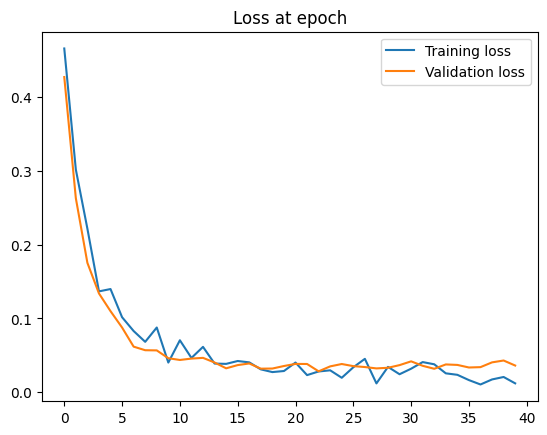

In [15]:
train_losses_items = [tl.item() for tl in train_losses]

# Graph the loss at epoch
plt.plot(train_losses_items, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Loss at epoch")
plt.legend()

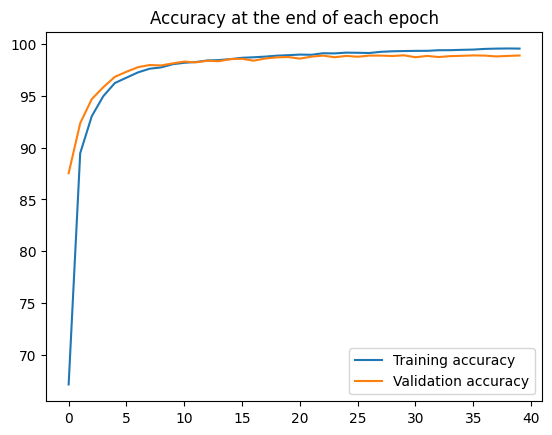

In [16]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training accuracy")
plt.plot([t/100 for t in test_correct], label="Validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [17]:
# Final testing of the model
final_test_data = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
  correct = 0
  for X_test, y_test in final_test_data:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

print(f'Model accuracy: {round(correct.item()/len(test_data)*100, 2)}%')

Model accuracy: 98.9%


##**Export model**

In [18]:
# Save into .pt and .onnx
%pip install onnx

torch.save(model.state_dict(), 'trained_model.pt')
torch.onnx.export(model, torch.randn(1, 1, 28, 28), "trained_model.onnx")